# Analysis of dynamical polarizability in the linear response formalism

We analyze the computation of the dynamical polarizabilityi inside the linear response formalism

In [2]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


First of all we compute the coupling matrix for various values of virtual orbitals

In [3]:
inp0 = {'dft' : 
        {'hgrids': 0.4,
         'gnrm_cv' : 1e-8,
         'itermax' : 100,
         'inputpsiid': 2},
        'tddft':{'tddft_approach': 'full'},
        'posinp': 'N2_posinp.xyz'}
Yaml.dump(inp0,outputpath + 'default.yaml')

In [4]:
numVirt=[16,32,64,128,256]

In [5]:
inp={'dft':
     {'rmult': [7.0, 9.0],
      'itermax_virt' : 1},
     'output': {
      'orbitals' : 'No'}, 
     'radical': 'Rmult_7.0'}
for n in numVirt:
    inp['dft']['norbv'] = -n
    inpname = 'NumVirt_'+str(n)
    Yaml.dump(inp,outputpath + inpname + '.yaml')

Execute one input file per time and copy by hand the coupling matrix and transition dipoles in the "TDDFT-Results" folder with the name coupling_matrix_n and transition_dipoles_n

In [6]:
code=C.SystemCalculator(omp=1,mpi=2)
%cd $outputpath
code.run(name='NumVirt_16',skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
Executing command:  OMP_NUM_THREADS=1 mpirun -np 2 $BIGDFT_ROOT/bigdft -n NumVirt_16 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


Read the data:

In [7]:
Data = []
%cd $outputpath
spath = 'log/'+str('log-NumVirt_')+str('*') 
logs = !ls $spath
print logs
for l in logs:
    Data.append(lf.Logfile(l))
# sort the Data list in the right order, with respect to the number of virtual orbitals
listnorbs=[len(l.evals[0][0]) for l in Data]
ipiv=np.argsort(listnorbs)
Data=[Data[i] for i in ipiv]
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
['log/log-NumVirt_128.yaml', 'log/log-NumVirt_16.yaml', 'log/log-NumVirt_256.yaml', 'log/log-NumVirt_32.yaml', 'log/log-NumVirt_64.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


Read the coupling matrix and dipoles for each value of the number of virtual orbitals

In [8]:
dipoles = []
C = []
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_*'
logs = !ls $dpath
print logs
for l in logs:
    dipoles.append(np.loadtxt(l))
listnorbs=[d.shape[0] for d in dipoles]
ipiv=np.argsort(listnorbs)
dipoles=[dipoles[i] for i in ipiv]

Cpath = 'log/TDDFT-Results/coupling_matrix_*'
logs = !ls $Cpath
print logs
for l in logs:
    C.append(np.loadtxt(l))
    
listnorbs=[c.shape[0] for c in C]
ipiv=np.argsort(listnorbs)
C=[C[i] for i in ipiv]
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
['log/TDDFT-Results/transition_dipoles_128.txt', 'log/TDDFT-Results/transition_dipoles_16.txt', 'log/TDDFT-Results/transition_dipoles_256.txt', 'log/TDDFT-Results/transition_dipoles_32.txt', 'log/TDDFT-Results/transition_dipoles_64.txt']
['log/TDDFT-Results/coupling_matrix_128.txt', 'log/TDDFT-Results/coupling_matrix_16.txt', 'log/TDDFT-Results/coupling_matrix_256.txt', 'log/TDDFT-Results/coupling_matrix_32.txt', 'log/TDDFT-Results/coupling_matrix_64.txt']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [9]:
dipoles[0][:,0] # the x component
print dipoles[4].shape[0]
print C[4].shape

2560
(2560, 2560)


We observe that $C$ is a symmetric matrix

In [9]:
np.allclose(C[4],C[4].T,atol=1.e-12)

True

## Spectral representation of the polarizability

Let us discuss the main formula needed for the computation of the polarizability. We consider
a dipole perturbation on the system so that the perturbing potential can be written as:
$$
\phi_j(\omega) = r_j F(\omega)
$$
$r_j$ indicates the direction of the field while the function $F$ keeps into account the amplitude of the pertubation and its $\omega$ dependence, and includes also the type of time evolution protocol (e.g. adiabatic or sudden). The expression of the induced dipole can be expressed in the basis of transition, according to the formula:
$$
d_{i}(\omega) = ( d_{i} | R(\omega) | d_{j}) F(\omega)
$$
Using the Casida formalism we have:
$$
d_{i}(\omega) = 2 \sum_{E^2} \frac{[d_i|C_{E^2}][\tilde C_{E^2}|d_j]}{(\omega+ 2i\eta)^2-E^2} F(\omega)
$$
where $|C_{E^2}]$ and $[\tilde C_{E^2}|$ are the right and left eigenvectors of the Casida matrix while $|d_i]$ and
$[d_j|$ represent the column and row vectors of components:
$$
d_i^{p\alpha} = T^{1/2}_{p\alpha} \int dr r_i \psi_p(r)\psi_{\alpha}(r)
$$

### Analysis of the statical polarizability

First of all we use this formalism to compare the value of the static polarizability given by this approach to the "exact" result obtained by explicitly adding a constant perturbing electric field in a DFT computation.
To perform this comparison we consider, in the linear response framework, a field switched on with an adiabatic protocol and we compute the (time dependent) induced dipole a t=0 (in which the damping factor of the adiabatic protocol is equal to one). Using the FT we have that:
$$
d_i(t=0) = \int \frac{d\omega}{2\pi} d_i(\omega)
$$
The F function associated to the adiabatic protocol of a constant perturbation of module equal to 1 is given by
$$
F(\omega) = \frac{2\tilde\eta}{\omega^2+\tilde\eta^2} 
$$
where $\tilde\eta$ is the damping parameter of the adiabatic protocol. For $\tilde\eta \rightarrow 0$ we recognize that this expression is equal to $2\pi\delta(\omega)$. So we have:
$$
d_i(t=0) = - 2 \sum_{E^2} \frac{[d_i|C_{E^2}][\tilde C_{E^2}|d_j]}{E^2}
$$
and this result has to reproduce, apart from the sign, the value of the static polarizability computed via a DFT computation.

In [8]:
#np.dot(C_E2.T[eigenvalue index],dipoles[numVirt])

In [9]:
alphaX = []
alphaY = []
alphaZ = []
for nind,nval in enumerate(numVirt):
    E2,C_E2=np.linalg.eigh(C[nind])
    R.validate_eigensystem(C[nind],E2,C_E2)
    sumx = 0.0
    sumy = 0.0
    sumz = 0.0
    for i,e in enumerate(E2):
        a = np.dot(C_E2.T[i],dipoles[nind])
        sumx+=2.0*a[0]*a[0]/e
        sumy+=2.0*a[1]*a[1]/e
        sumz+=2.0*a[2]*a[2]/e
    alphaX.append(sumx)
    alphaY.append(sumy)
    alphaZ.append(sumz)
print alphaX
print alphaY
print alphaZ

Validation terminated
Validation terminated
Validation terminated
Validation terminated
Validation terminated
[7.3652949235158021, 9.6242684281771655, 9.9364596435103074, 10.674896451768692, 10.810435542168234]
[7.3652950885610453, 9.624268446200837, 9.9364604951900208, 10.674900405725804, 10.809683402363975]
[11.059355580932314, 13.34246728190128, 14.112372652233761, 15.130321005997805, 15.477065014764865]


We plot these values together with the reference results

In [10]:
alphaX_ref = 10.87
alphaZ_ref = 15.74

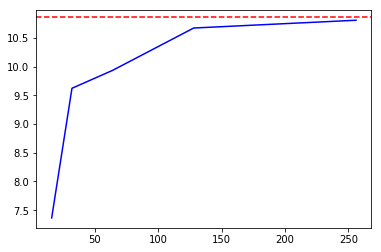

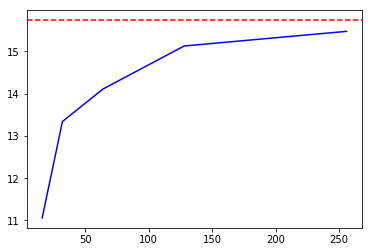

In [11]:
plt.plot(numVirt,alphaX,color ='b')
plt.axhline(y=alphaX_ref, color='r', linestyle='--')
plt.show()
plt.plot(numVirt,alphaZ,color='b')
plt.axhline(y=alphaZ_ref, color='r', linestyle='--')
plt.show()

### Dynamical polarizability in the adiabatic case

We compute the induced dipole in the adiabatic case. 
We consider a monocromatic perturbation of the form $H_1(t) = r_jcos(\omega_0 t)$. Using the formula for the
adiabatic case presented in the note, and remembering the representation of the delta function in terms of
a lorentzian we have that:
$$
F(\omega) = \pi\left(\delta(\omega-\omega_0) + \delta(\omega+\omega_0)\right)
$$
So, the induced dipole is nonvashing only for $\omega = \pm\omega_0$ and reads:
$$
d_{i}(\omega) = 2\pi\sum_{E^2} \frac{[d_i|C_{E^2}][\tilde C_{E^2}|d_j]}{(\omega+ 2i\eta)^2-E^2} \left(\delta(\omega-\omega_0)+ \delta(\omega+\omega_0) \right)
$$

We observe that $d_i(\omega)$ satisfies the property $d_i^{*}(\omega)=d_i(-\omega)$. This condition ensures that $d_i(t)$ is real. Performing the inverse FT we have:
$$
d_i(t) = \left[\sum_{E^2} \frac{[d_i|C_{E^2}][\tilde C_{E^2}|d_j]}{(\omega_0+ 2i\eta)^2-E^2}e^{-i\omega_0 t}+\sum_{E^2} \frac{[d_i|C_{E^2}][\tilde C_{E^2}|d_j]}{(\omega_0-2i\eta)^2-E^2}e^{i\omega_0 t}\right]
$$
We write this quantity in the form:
$$
d_i(t) = A(\omega_0)e^{-i\omega_0 t} + A^*(\omega_0)e^{i\omega_0 t}
$$
and introducing the polar representation for $A(\omega_0)=|A(\omega_0)|e^{i\phi(\omega)}$ we have:
$$
d_i(t) = 2|A(\omega_0)|cos(\omega_0 t + \phi(\omega_0)
$$

Now we want to plot $A(\omega_0)$ in function of $\omega_0$. We choose $r_j = z$ and compute $d_z$ so, remembering that $C$ is real and symmetric we have to compute the modulus and phase of the quantity:
$$
A(\omega_0) = \sum_{E^2} \frac{[d_z|C_{E^2}]^2}{(\omega_0+ 2i\eta)^2-E^2}
$$
We consider the case with 256 empty orbitals and compute the square root of the highest eigenvalue of $C$. This value si used to understand up to which $\omega_0$ is meaningfull to compute $A$. 

In [31]:
E2,C_E2=np.linalg.eigh(C[len(numVirt)-1])
nE2 = len(E2) #numbers of eigenvalues
print nE2
E2maxSR = np.sqrt(E2[-1]) #square root of the highest eigenvalues
print E2maxSR

2560
2.59740646193


In [50]:
npoint = 1000
eta = 1.0e-2
omegaMax = E2maxSR + 0.1
omega = np.linspace(0.0,omegaMax,npoint)
A = np.zeros(npoint, dtype=complex)
fE = []
for i in range(nE2):
    fE.append(np.dot(C_E2.T[i],dipoles[len(numVirt)-1][:,2]))
for ind,o in enumerate(omega):
    s = 0.0
    for i,e in enumerate(E2):
        s+=fE[i]**2/(complex(o,2*eta)**2-e)
    A[ind] = s

In [51]:
modA = np.abs(A)
phiA = np.imag(A)/np.real(A)

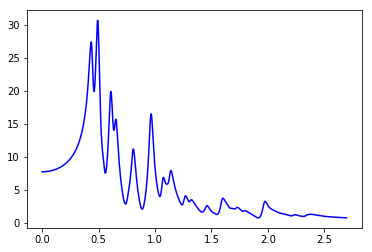

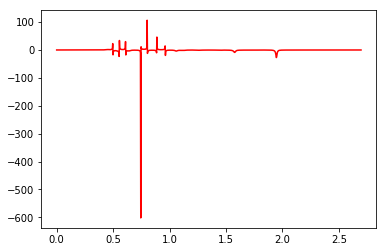

In [52]:
plt.plot(omega,modA,color ='b')
plt.show()
plt.plot(omega,phiA,color ='r')
plt.show()

It is also interesting to compute the real and imaginary part of $A$ (with a minus sign!) that are related to the real and imaginary part of the index of refraction

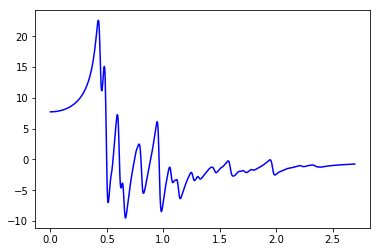

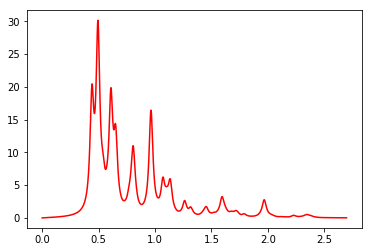

In [53]:
plt.plot(omega,-np.real(A),color ='b')
plt.show()
plt.plot(omega,-np.imag(A),color ='r')
plt.show()

### Constant perturbation in the sudden limit

We consider a constant perturbation $H_1=1$, abruptly switched on at $t=0$. Using the formula for the sudden limit applied to this case we have that:
$$
F(\omega) = \frac{i}{\omega+i\eta} = \theta(\omega)
$$
Again we assume that the perturbation is along the $z$ axis and we compute the induced dipole along the same axis. So, introducing the notation $f(E) = [d_z|C_{E^2}]$ we have:
$$
d_{z}(\omega) = 2 \sum_{E^2} \frac{f(E)^2}{(\omega+ 2i\eta)^2-E^2} \theta(\omega)
$$
Also in this case we observe that $d_z^{*}(\omega) = d_z(-\omega)$ so that $d_z(t)$ is real.
Since $d_{z}(\omega)$ is expressed as the product of two functions (one is the $\theta(\omega)$ while the other one will be denoted as $A(\omega)$), its inverse FT can be written as the convolution of the inverse FT of the two factors, that is:
$$
d_z(t) = \int_{-\infty}^{\infty} dt' \theta(t') A(t-t') = \int_{0}^{\infty} dt' A(t-t') 
$$
Let us compute the expression of $A(t)$. We have that:
$$
A(t) = \frac{1}{\pi}\sum_{E^2}f(E)^2 \int_{-\infty}^{\infty}d\omega\frac{e^{-i\omega t}}
{(\omega+ 2i\eta)^2-E^2}
$$
The last integral can be computed with the residue method. The poles are in $\bar\omega^+\equiv E-2i\eta$ and in 
$\bar\omega^-\equiv -E-2i\eta$, both in the lower half plane. Extending the integrand in the complex plane we have that $-i\omega t \rightarrow-ixt + yt$ so for $t>0$ we have to close the path below (pole inside the domain), while for $t<0$ we have to close above and the integral is zero.
We observe that the integrand can be written as:
$$
\frac{e^{-i\omega t}} {(\omega+ 2i\eta)^2-E^2} = \frac{e^{-i\omega t}} {(\omega-\bar\omega^+)(\omega+2i\eta+E)} 
$$
and also as:
$$
\frac{e^{-i\omega t}} {(\omega+ 2i\eta)^2-E^2} = \frac{e^{-i\omega t}} {(\omega-\bar\omega^-)(\omega+2i\eta-E)} 
$$
so the values of the residue in $\bar\omega^{\pm}$ are:
$$
\frac{e^{-iE t}e^{-2\eta t}} {2E} \;,\qquad
-\frac{e^{iE t}e^{-2\eta t}} {2E}
$$
Putting these results togethere we have:
$$
A(t) = \frac{\theta(t)}{\pi}\sum_{E^2}f(E)^2 (-2\pi i) \frac{e^{-iE t}e^{-2\eta t}-e^{iE t}e^{-2\eta t}} {2E} =
-i\theta(t)\sum_{E^2}f(E)^2 \frac{e^{-iE t}e^{-2\eta t}-e^{iE t}e^{-2\eta t}} {E}
$$
Plugging this result in the formula for $d_z(t)$ provides:
$$
d_z(t) = -i\sum_{E^2}\frac{f(E)^2}{E} \int_{0}^{t}dt'\left(
e^{-iE (t-t')}e^{-2\eta (t-t')}-e^{iE (t-t')}e^{-2\eta (t-t')} \right)
$$
We observe that time dependence of the integral is consistent both with the fact the perturbation is switched on at $t=0$
and with the causality condition. Performing the last integral provides:
$$
d_z(t) = -i\sum_{E^2}\frac{f(E)^2}{E} \left[\frac{1}{iE+2\eta}\left(1-e^{-iE t}e^{-2\eta t}\right) - 
\frac{1}{-iE+2\eta}\left(1-e^{iE t}e^{-2\eta t}\right)
\right]
$$
the $\eta$ term in the denominator can be dropped out and we obtain:
$$
d_z(t) = -2\sum_{E^2}\frac{f(E)^2}{E^2}\left[1-cos(Et)e^{-2\eta t}\right]
$$

We want to plot $d_z(t)$ (with the minus sign to compare with the result obtained in the static case). To find a good choice of sampling of the $t$ variable we observe that, for each value of $E$, the period of the oscillating function is $2\pi/E$. So, for instance, we can sample up to $T_{max} = 8/(2\eta)$ (to ensure that the damping factors has produced the asimptotic result) with a time step lower than $2\pi/E_{max}$

In [10]:
E2,C_E2=np.linalg.eigh(C[len(numVirt)-1])
nE2 = len(E2) #numbers of eigenvalues
print nE2
E2maxSR = np.sqrt(E2[-1]) #square root of the highest eigenvalues
E2minSR = np.sqrt(E2[0])
print E2minSR, E2maxSR

2560
0.268654196567 2.59740646193


In [53]:
npoint = 500
eta = 1.0e-2
tMax = 8/(2*eta)
tMin = 2*np.pi/E2maxSR
print tMin, tMax
t = np.linspace(0.0,tMax,npoint)
dz = np.zeros(npoint, dtype=complex)
fE = []
for i in range(nE2):
    fE.append(np.dot(C_E2.T[i],dipoles[len(numVirt)-1][:,2]))
for ind,tt in enumerate(t):
    s = 0.0
    for i,e in enumerate(E2):
        s+=2.0*fE[i]**2/e*(1.0-np.cos(np.sqrt(e)*tt)*np.exp(-eta*tt))
    dz[ind] = s

2.41902274414 400.0


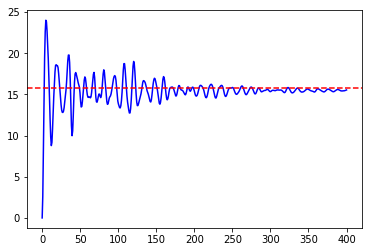

In [54]:
alphaZ_ref = 15.74
plt.plot(t,dz,color ='b')
plt.axhline(y=alphaZ_ref, color='r', linestyle='--')
plt.show()